In [16]:
import pykat
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

pykat.init_pykat_plotting()

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

from sympy import *
from sympy.solvers.solveset import linsolve

init_printing()

# Analytics

In [17]:
a1, a2, a3, a4, a2a, a2b, z, E0 = var('a_1, a_2, a_3, a_4, a_{2a}, a_{2b}, z, E_0')
r, t, R, T, L, phi, k, omega, Omega = var('r,t,R,T,L,phi,k,omega,Omega', real=True)

# Carrier calculations

In [18]:
eqns = [
    -a1  + E0,
    -a2  + I*t*a1 + r*a3,
    -a2a + a2*exp(-I*k*L*Omega/omega), # No carrier phase, assume always on resonance for 0Hz
    -a2b + a2a*exp(2*I*phi), # ETM moves towards ITM so shorter cavity, opposite sign to exp(-ikL)
    -a3  + a2b*exp(-I*k*L*Omega/omega),
    -a4  + r*a1 + I*t*a3
] 

b = linsolve(eqns, (a1,a2,a2a,a2b,a3,a4))

b1,b2,b2a,b2b,b3,b4 = b.args[0]

subs = {
    k: 2*pi/1064e-9,
    r: sqrt(R),
    t: sqrt(T),
    omega: 299792458*2*pi/1064e-9,
    Omega: 0 # carrier field
}

f_c1 = lambdify((E0, R, T, L, phi), b1.subs(subs))
f_c2 = lambdify((E0, R, T, L, phi), b2.subs(subs))
f_c2a= lambdify((E0, R, T, L, phi), b2a.subs(subs))
f_c2b= lambdify((E0, R, T, L, phi), b2b.subs(subs))
f_c3 = lambdify((E0, R, T, L, phi), b3.subs(subs))
f_c4 = lambdify((E0, R, T, L, phi), b4.subs(subs))

In [19]:
# Check that carrier fields are the same amplitude and phase
# each pair of values printed should be equal

kat = pykat.finesse.kat()
kat.parse("""
l Laser 3 0 0.0 nBS1a
bs1 IMy 0.01 0.0 0.0 0 nBS1a nBS1b nIMy2a nIMy2b
attr IMy mass 0.1
s yArma 0.0 nIMy2a nEMy1a
s yArmb 0.0 nIMy2b nEMy1b
bs1 EMy 0 0 -0.001 0 nEMy1a nEMy1b nEMy2a nEMy2b

xd ITM1 IMy z
qnoised noise 1  $fs nBS1b
pd1 sig $fs nBS1b

ad c1 0 nBS1a*
ad c2 0 nIMy2a
ad c2a 0 nEMy1a*
ad c2b 0 nEMy1b
ad c3 0 nIMy2b*
ad c4 0 nBS1b

ad u $fs nBS1a
ad l $mfs nBS1a

xaxis sig1 f log 0.1 1000 10000
fsig sig1 EMy z 1.0 0.0 1.0
maxtem off

yaxis log abs:deg
""", keepComments=True)

out = kat.run()

args = (np.sqrt(3), 1-kat.IMy.T.value, kat.IMy.T.value, kat.yArma.L.value, np.deg2rad(kat.EMy.phi.value))

print('c1')
print(abs(out['c1'])[0], abs(f_c1(*args)))
print(np.angle(out['c1'])[0], np.angle(f_c1(*args)))
print('c2')
print(abs(out['c2'])[0], abs(f_c2(*args)))
print(np.angle(out['c2'])[0], np.angle(f_c2(*args)))
print('c2a')
print(abs(out['c2a'])[0], abs(f_c2a(*args)))
print(np.angle(out['c2a'])[0], np.angle(f_c2a(*args)))
print('c2b')
print(abs(out['c2b'])[0], abs(f_c2b(*args)))
print(np.angle(out['c2b'])[0], np.angle(f_c2b(*args)))
print('c3')
print(abs(out['c3'])[0], abs(f_c3(*args)))
print(np.angle(out['c3'])[0], np.angle(f_c3(*args)))
print('c4')
print(abs(out['c4'])[0], abs(f_c4(*args)))
print(np.angle(out['c4'])[0], np.angle(f_c4(*args)))

--------------------------------------------------------------
Running kat - Started at 2018-01-29 21:15:00.396687


100% | ETA:  0:00:00 | Calculating                                             


Finished in 0.446432 seconds
c1
1.73205080757 1.73205080757
0.0 0.0
c2
34.5533623961 34.5533623961
1.56386752524 1.56386752524
c2a
34.5533623961 34.5533623961
1.56386752524 1.56386752524
c2b
34.5533623961 34.5533623961
1.56383261865 1.56383261865
c3
34.5533623961 34.5533623961
1.56383261865 1.56383261865
c4
1.73205080757 1.73205080757
3.12770014389 3.12770014389


# upper and lower

Make some equations for the sidebands

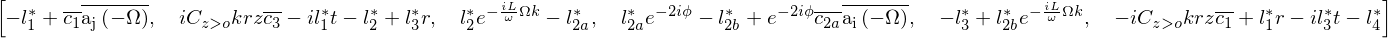

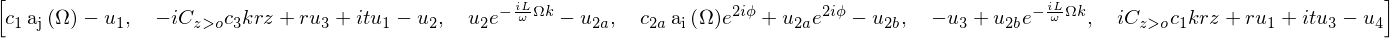

In [20]:
c1, c2, c2a, c2b, c3, c4 = var('c_1, c_2, c_{2a}, c_{2b}, c_3, c_4') # carrier fields at each port
C_oz = var('C_{o>z}', real=True) # Constant for scaling optic -> motion
C_zo = var('C_{z>o}', real=True) # Constant for scaling motion -> optic

z = var('z') # motion of mirror
ai = Function('a_i') # intracavity sideband source 
aj = Function('a_j') # injected sideband source 

sb_eqns = eqns.copy()

# no source of sidebands at input so remove it...
sb_eqns[0] -= E0
sb_eqns[0] += aj(Omega) * c1

# 2 from exponent, 1/2 from cos = 1/2(exp(+)+exp(-))
# 2j as we expand exp(2jkz) term
sb_eqns[5] += C_zo*r*c1*2*I*k*z/2    # outer cavity reflection
sb_eqns[1] += -1*C_zo*r*c3*2*I*k*z/2 # intra cavity reflection, positive z means longer cavity, hence minus sign


# Source of sidebands from moving ETM
# Take incident carrier and reflect it from ETM
sb_eqns[3] += ai(Omega)*(c2a)*exp(2*I*phi)

# Now I make copies of the general field and generate upper and conjugate lower sideband equations

# upper sidebands terms
u1, u2, u2a, u2b, u3, u4 = var('u_1, u_2, u_{2a}, u_{2b}, u_3, u_4')

# lower sideband terms (We solve for the conjugate of the lower sideband), * is just symbolic here
l1, l2, l2a, l2b, l3, l4 = var('l^*_1, l^*_2, l^*_{2a}, l^*_{2b}, l^*_3, l^*_4')

up_eqns = sb_eqns.copy()
lo_eqns = sb_eqns.copy()

for i in range(len(sb_eqns)):
    up_eqns[i] = up_eqns[i].subs({a1:u1,
                                  a2:u2,
                                  a2a:u2a,
                                  a2b:u2b,
                                  a3:u3,
                                  a4:u4})
    
    lo_eqns[i] = lo_eqns[i].conjugate().subs({Omega:-Omega,
                                  a1:l1.conjugate(),
                                  a2:l2.conjugate(),
                                  a2a:l2a.conjugate(),
                                  a2b:l2b.conjugate(),
                                  a3:l3.conjugate(),
                                  a4:l4.conjugate()})
    
    # z is real spectrum, so negative part is conjugate of positive frequency
    lo_eqns[i] = lo_eqns[i].replace(z, z.conjugate())
    
display(lo_eqns)
display(up_eqns)

# Radiation pressure

In [21]:
M,c = var('M, c', real=True)

# power fluctuations at each port
P1 = Function('P_1')(Omega) 
P2 = Function('P_2')(Omega)
P3 = Function('P_3')(Omega)
P4 = Function('P_4')(Omega)

# Free mass - force to z
H_F_z = -1/(M*Omega**2)

Here we define how the power flucutations at each port contribute to the total force exerted on the mirror. Remember here that the definition of positive power force in port 1 creates a negative force, as the z-motion is defined by the surface normal of side 1 of a mirror (where ports 1 and 4 in this case are). Power from port 4 also has negative, as when the mirror is perfectly reflective we need $F_{rp} = -2P(\Omega)/c$, where the power in 1 and 4 is the same. On side 2 a positive power will force the mirror in the positive z direction.

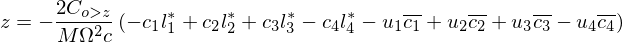

In [22]:
# factor of two beacuse we also have the negative frequency terms
# Finesse scales the power by two internally
Frp = C_oz * 2 * (- P1 - P4 + P2 + P3) / c

Frp = Frp.subs({
    P1: u1*c1.conjugate() + l1*c1,
    P2: u2*c2.conjugate() + l2*c2,
    P3: u3*c3.conjugate() + l3*c3,
    P4: u4*c4.conjugate() + l4*c4
})

Z = H_F_z * Frp


display( Eq(z,Z) )

# Combine and solve...

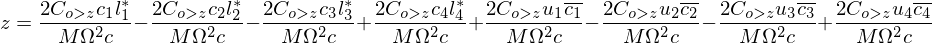

In [23]:
#Equations we are going to solve
eqns2 = []
eqns2.extend(lo_eqns)
eqns2.extend(up_eqns)
eqns2.extend([(Z-z).expand()])

for _,__ in zip((l1,
             l2,
             l2a,
             l2b,
             l3,
             l4,
             u1,
             u2,
             u2a,
             u2b,
             u3,
             u4,
             z),eqns2):
    display(Eq(_,__+_))

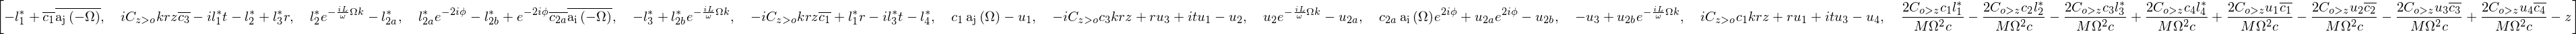

In [24]:
# Solving the equations takes awhile to run...

display(eqns2)

sol = linsolve(eqns2,
            (l1,
             l2,
             l2a,
             l2b,
             l3,
             l4,
             u1,
             u2,
             u2a,
             u2b,
             u3,
             u4,
             z))

# put solutions in a dictionary...
sols = {}

for _v,_var in zip(sol.args[0], (l1,l2,l2a,l2b,l3,l4, u1,u2,u2a,u2b,u3,u4, z)):
    sols[_var] = _v

In [25]:
def _plot(func, var, title, plot_func="loglog", unwrap=True):
    if unwrap:
        fn_unwrap = np.unwrap
    else:
        fn_unwrap = lambda x: x
        
    Y = func(Omegas)
    
    if len(np.atleast_1d(Y)) == 1:
        Y = np.ones_like(Omegas) * Y
    
    fig = plt.figure(figsize=(12,4))
    gs1 = gridspec.GridSpec(3, 2)
    gs1.update(wspace=0.2, hspace=0.05) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0:2,0])
    getattr(ax1, plot_func)(Omegas/(2*np.pi), abs(Y), label="Analytic")
    getattr(ax1, plot_func)(out.x, abs(out[var]), label="Finesse", ls='--')
    ax1.legend(fontsize=11)
    ax1.set_title(title, fontsize=11)
    ax1.set_ylabel("Amplitude [m]", fontsize=11)
    ax1.set_xticklabels([])
    ax1.set_xlim(out.x.min(), out.x.max())

    ax1 = plt.subplot(gs1[2,0])
    ax1.loglog(Omegas/(2*np.pi), abs(abs(Y)-abs(out[var]))/abs(Y), c='k')
    ax1.set_ylabel("Relative residual", fontsize=11)
    ax1.set_xlabel("Frequency [Hz]", fontsize=11)
    ax1.set_xlim(out.x.min(), out.x.max())

    ax1 = plt.subplot(gs1[0:2,1])
    ax1.semilogx(Omegas/(2*np.pi), fn_unwrap(np.angle(Y)), label="Analytic")
    ax1.semilogx(out.x, fn_unwrap(np.angle(out[var])), label="Finesse", ls='--')
    ax1.legend(fontsize=11)
    ax1.set_title(title, fontsize=11)
    ax1.set_ylabel("Phase [rad]", fontsize=11)
    ax1.set_xticklabels([])
    ax1.set_xlim(out.x.min(), out.x.max())


    ax1 = plt.subplot(gs1[2,1])
    ax1.semilogx(Omegas/(2*np.pi), abs(np.angle(Y)-np.angle(out[var])), c='k')
    ax1.set_ylabel("Residual", fontsize=11)
    ax1.set_xlabel("Frequency [Hz]", fontsize=11)
    ax1.set_xlim(out.x.min(), out.x.max())

In [37]:
# The power injected in Finesse is P Watts. However
# we only model a single sided spectrum, so need another factor
# of two for the negative half we're missing
P = 1

_R = 0.99
_T = 1-_R
_phi = np.deg2rad(-0.002) # negative tuning on ETM, makes cavity longer for optical spring
_mass = 0.1
_L = 1000 # set L to zero so we ignore those minus signs for now

ain = 1 * 2 * I * k * 1 /2 #2j*k*z/2 # ETM generated phase sideband amplitude
ajn = 0 * 1/4

# Make a comparable Finesse model
kat = pykat.finesse.kat()
kat.parse("""
l Laser 1.0 0 0.0 nBS1a
bs IMy 0.99 0.01 0.0 0.0 nBS1a nBS1b nIMy2a nIMy2b
attr IMy mass 0.1
s yArma 1000 nIMy2a nEMy1a
s yArmb 1000 nEMy1b nIMy2b 
bs EMy 1.0 0.0 -0.002 0.0 nEMy1a nEMy1b nEMy2a nEMy2b


xd ITM1 IMy z
xd ETM1 EMy z

ad c1 0 nBS1a*
ad c2 0 nIMy2a
ad c2a 0 nEMy1a*
ad c2b 0 nEMy1b
ad c3 0 nIMy2b*
ad c4 0 nBS1b
ad u1 $fs nBS1a*
ad u2 $fs nIMy2a
ad u2a $fs nEMy1a*
ad u2b $fs nEMy1b
ad u3 $fs nIMy2b*
ad u4 $fs nBS1b
ad l1 $mfs nBS1a*
ad l2 $mfs nIMy2a
ad l2a $mfs nEMy1a*
ad l2b $mfs nEMy1b
ad l3 $mfs nIMy2b*
ad l4 $mfs nBS1b

xaxis sig1 f log 0.1 100000 1001
#fsig sig1 Laser phase 1.0 0.0 1.0
fsig sig1 EMy z 1.0 0.0 1.0

phase 2
maxtem off
yaxis log abs:deg
""", keepComments=True)

kat.Laser.P = P # counteract extra factor of two from above as Finesse does this internally
kat.IMy.R = _R
kat.IMy.T = _T
kat.EMy.phi = np.rad2deg(_phi)

if _mass is oo:
    pass
    #kat.IMy.mass = "inf"
else:
    kat.IMy.mass = _mass
    
kat.yArma.L.value = abs(_L)
kat.yArmb.L.value = abs(_L)

out = kat.run()

Omegas = 2 * np.pi * out.x

values = {
    k: 2*pi/1064e-9,
    L: _L,
    r: sqrt(_R),
    t: sqrt(_T),
    omega: 299792458*2*pi/1064e-9,
    ai(Omega): 1*ain,
    ai(-Omega): 1*ain,
    aj(Omega): ajn,
    aj(-Omega): ajn,
    M: _mass,
    C_zo: 1,
    C_oz: 1,
    c: 299792458,
    phi: _phi,
    # Insert all the carrier field amplitudes
    c1:  f_c1(sqrt(P), _R, _T, _L, _phi).n(), 
    c2:  f_c2(sqrt(P), _R, _T, _L, _phi).n(),
    c2a: f_c2a(sqrt(P), _R, _T, _L, _phi).n(),
    c2b: f_c2b(sqrt(P), _R, _T, _L, _phi).n(),
    c3:  f_c3(sqrt(P), _R, _T, _L, _phi).n(),
    c4:  f_c4(sqrt(P), _R, _T, _L, _phi).n()
}

if _mass is oo:
    values[C_zo] = 0
    values[C_oz] = 0 

fz   = lambdify((Omega, ), sols[z].subs(values).n())
fu1  = lambdify((Omega, ), sols[u1].subs(values).n())
fu2  = lambdify((Omega, ), sols[u2].subs(values).n())
fu3  = lambdify((Omega, ), sols[u3].subs(values).n())
fu4  = lambdify((Omega, ), sols[u4].subs(values).n())

fl1 = lambdify((Omega, ), sols[l1].subs(values).n().conjugate())
fl2 = lambdify((Omega, ), sols[l2].subs(values).n().conjugate())
fl3 = lambdify((Omega, ), sols[l3].subs(values).n().conjugate())
fl4 = lambdify((Omega, ), sols[l4].subs(values).n().conjugate())

print("Done")

--------------------------------------------------------------
Running kat - Started at 2018-01-29 23:19:37.078053

Finished in 0.143561 seconds


100% | ETA:  0:00:00 | Calculating                                             

Done


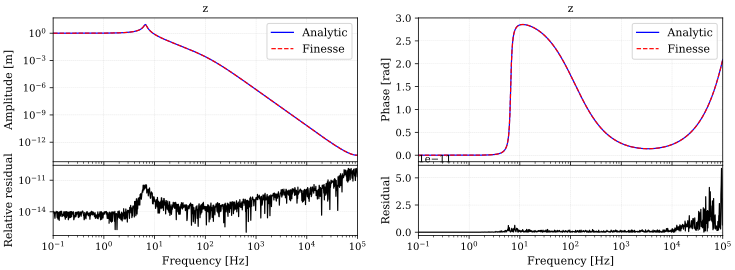

In [38]:
_plot(fz, "ITM1", "z", "loglog", unwrap=False)

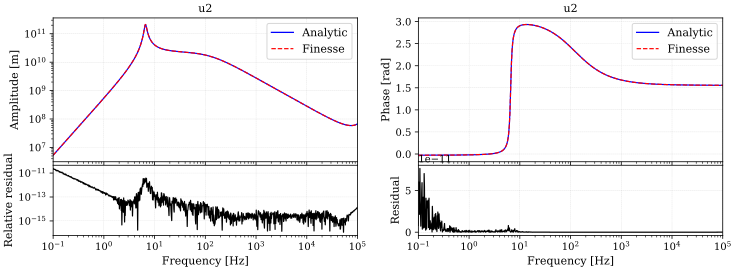

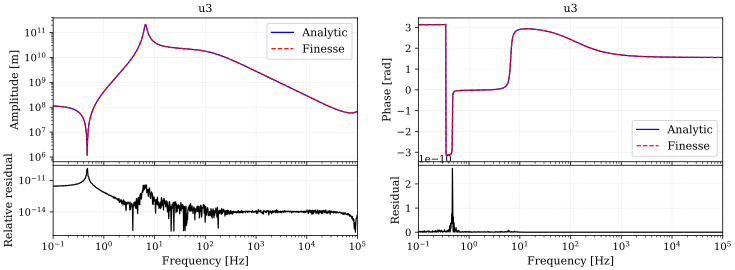

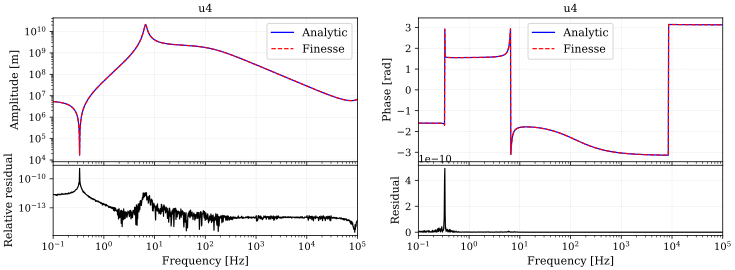

In [39]:
_plot(fu2, "u2", "u2", "loglog", unwrap=False)
_plot(fu3, "u3", "u3", "loglog", unwrap=False)
_plot(fu4, "u4", "u4", "loglog", unwrap=False)

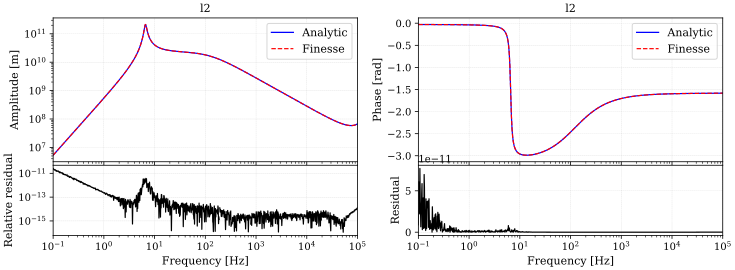

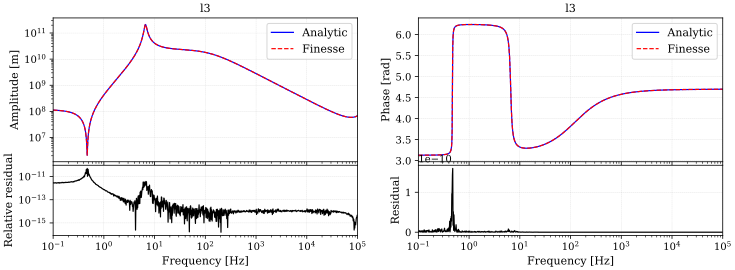

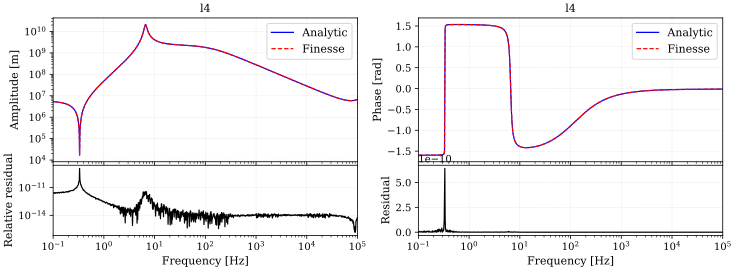

In [40]:
_plot(fl2, "l2", "l2", "loglog")
_plot(fl3, "l3", "l3", "loglog")
_plot(fl4, "l4", "l4", "loglog")

# The kat that ran...

In [41]:
print(kat)

% Generated by PyKat 29.01.2018 23:20:09

l Laser 1.0 0 0.0 nBS1a
bs IMy 0.99 0.010000000000000009 0.0 0.0 nBS1a nBS1b nIMy2a nIMy2b
attr IMy mass 0.1
s yArma 1000 nIMy2a nEMy1a
s yArmb 1000 nEMy1b nIMy2b
bs EMy 1.0 0.0 -0.002 0.0 nEMy1a nEMy1b nEMy2a nEMy2b
xd ITM1 IMy z
xd ETM1 EMy z
ad c1 0 nBS1a*
ad c2 0 nIMy2a
ad c2a 0 nEMy1a*
ad c2b 0 nEMy1b
ad c3 0 nIMy2b*
ad c4 0 nBS1b
ad u1 $fs nBS1a*
ad u2 $fs nIMy2a
ad u2a $fs nEMy1a*
ad u2b $fs nEMy1b
ad u3 $fs nIMy2b*
ad u4 $fs nBS1b
ad l1 $mfs nBS1a*
ad l2 $mfs nIMy2a
ad l2a $mfs nEMy1a*
ad l2b $mfs nEMy1b
ad l3 $mfs nIMy2b*
ad l4 $mfs nBS1b
xaxis sig1 f log 0.1 100000 1001
#fsig sig1 Laser phase 1.0 0.0 1.0
fsig sig1 EMy z 1.0 0.0 1.0
phase 2
maxtem off
yaxis log abs:deg

